## GAN
Generative adversarial network (GAN) is a powerful deep generative model. It is capable of synthesising realistic images. For example, DeepFake uses GAN to swap faces in the video. 
![img](gan.png)

There is a competition going on in the GAN. There is a discriminator that tries to tell the fake image from the real image. There is also a generator that generates fake images and tries to fool the discriminator. The competition between the two encourages both of them to improve. At the end, we have a good generator that is able to generate realistic images.


### Install a facial landmark package for the first time

In [1]:
!pip install face-alignment

You should consider upgrading via the 'pip install --upgrade pip' command.


### Import packages

In [2]:
from skimage.io import imsave
import torch
from torchvision.transforms import Compose, Resize, CenterCrop
import numpy as np
from PIL import Image
import face_alignment
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from models import *
import cv2
import pdb
import glob
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### define helper functions

In [3]:
def denorm(tensor):
    return ((tensor+1.0)/2.0)*255.0

def norm(image):
    return (image/255.0-0.5)*2.0

transforms = Compose([
                CenterCrop(135),
                Resize(128)
                ])

def get_z_random(batch, nz):
    z = torch.FloatTensor(batch, nz)
    z.copy_(torch.randn(batch, nz))
    return z 


### Load input image

In [4]:
img = Image.open('images/6.jpg').convert('RGB')
img = np.array(img)

### Import facial landmark algorithm

In [5]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')
preds = fa.get_landmarks(img)

### Draw landmarks on face

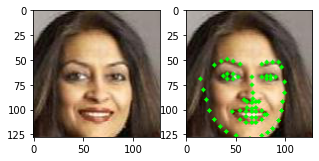

In [6]:
input_with_FL = img.copy()
for (x, y) in preds[0]:
   cv2.circle(input_with_FL, (x, y), 2, (0, 255, 0), -1)

plt.rcParams["figure.figsize"] = (5,3)
plt.subplot(1,2,1); plt.imshow(img)
plt.subplot(1,2,2); plt.imshow(input_with_FL)

### detect the bounding box around the face

In [7]:
pts = np.array(preds[0])
x_min = pts[:,0].min()
x_max = pts[:,0].max()
y_min = pts[:,1].min()
y_max = pts[:,1].max()

In [8]:
img.shape

(128, 128, 3)

In [9]:
# crop the face and resize it if larger than given size 128
if img.shape[0] > 128:
    img = Image.fromarray(img)
    y_extend = 2 / 3 * (y_max - y_min)
    img = img.crop((x_min-y_extend//2, y_min-y_extend, x_max+y_extend//2, y_max)).resize((128,128))
    img = np.array(img)
    plt.imshow(img)

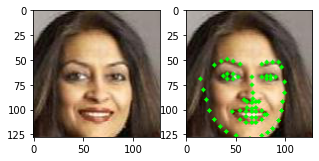

In [10]:
# detect landmarks again
preds = fa.get_landmarks(img)
input_with_FL = img.copy()
for (x, y) in preds[0]:
   cv2.circle(input_with_FL, (x, y), 2, (0, 255, 0), -1)

plt.rcParams["figure.figsize"] = (5,3)
plt.subplot(1,2,1); plt.imshow(img)
plt.subplot(1,2,2); plt.imshow(input_with_FL)

### crop the face using facial landmarks

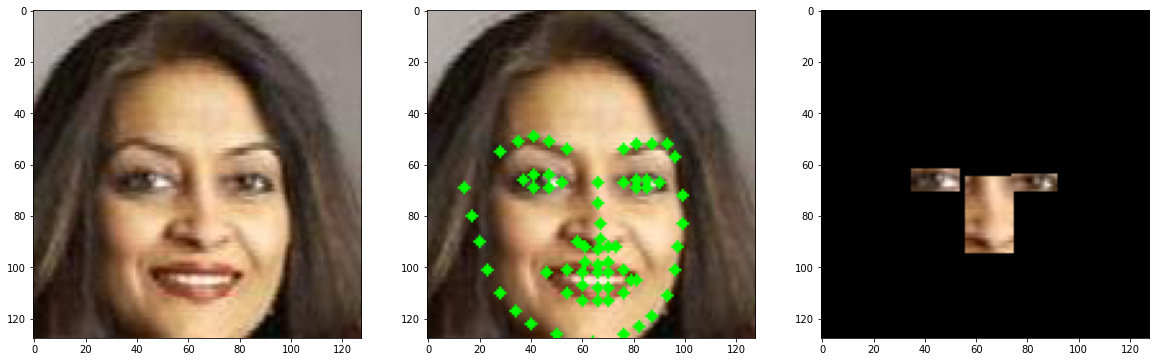

In [11]:
def get_face_mask(img, preds):
    mask = np.zeros((img.shape[0], img.shape[1]))

    ############### left eye ####################
    left_eye = preds[0][36:42]
    n = 2
    left_eye_mask = np.zeros((img.shape[0], img.shape[1]))
    left_eye_mask[int(min(left_eye[:,1])-n):int(max(left_eye[:,1])+n), int(min(left_eye[:,0])-n):int(max(left_eye[:,0])+n)] = 1

    ############### right eye ####################
    right_eye = preds[0][42:48]
    n = 2
    right_eye_mask = np.zeros((img.shape[0], img.shape[1]))
    right_eye_mask[int(min(right_eye[:,1])-n):int(max(right_eye[:,1])+n), int(min(right_eye[:,0])-n):int(max(right_eye[:,0])+n)] = 1

    ############### nose ####################
    nose = preds[0][27:36]
    n = 2
    nose_mask = np.zeros((img.shape[0], img.shape[1]))
    nose_mask[int(min(nose[:,1])-n):int(max(nose[:,1])+n), int(min(nose[:,0])-n):int(max(nose[:,0])+n)] = 1

    mask += left_eye_mask
    mask += right_eye_mask
    mask += nose_mask
    mask[mask>0] = 1

    crop_face = np.zeros((img.shape))
    for i in range(3):
        crop_face[:,:,i] = img[:,:,i]*mask
    return mask, crop_face
mask, crop_face = get_face_mask(img, preds)
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1,3,1); plt.imshow(img)
plt.subplot(1,3,2); plt.imshow(input_with_FL)
plt.subplot(1,3,3); plt.imshow(crop_face/255)

### Hallucinate the whole face using GAN

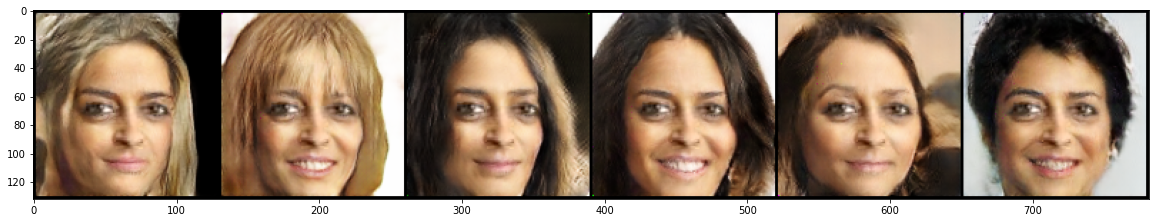

In [12]:
num_sample = 6 # number of faces you want to sample
    
rgb =  torch.from_numpy(crop_face).unsqueeze(0).transpose(1,3).transpose(2,3).float() # torch.ones((1,3,128,128))
mask = torch.from_numpy(mask).unsqueeze(0).float()[None, :] # mask = torch.ones((1,3,128,128))
# process inptus
mask[mask>0] = 1
cond_input = rgb*mask
rgb, cond_input = norm(rgb), norm(cond_input)

# load models
encoder = torch.load('models/encoder_29.pt', map_location=lambda storage, loc: storage)
decoder = torch.load('models/decoder_29.pt', map_location=lambda storage, loc: storage)

# Sample Style Code 
batch = rgb.shape[0]
style_codes = torch.FloatTensor(batch, num_sample, 512).uniform_().view(-1,512)

# Encode occluded face image 
code = encoder(cond_input)

# Decode face image
rgb_hat = decoder(code, style_codes)[-1]

output = torch.zeros_like(rgb_hat)
for i in range(num_sample):
    output[i] = mask * rgb + (1 - mask) * rgb_hat[i]
demo = make_grid(output, nrow=num_sample, padding=2, normalize=True)
demo_np = demo.transpose(0,2).transpose(0,1).detach().numpy()
plt.imshow(demo_np)

## Try you own image

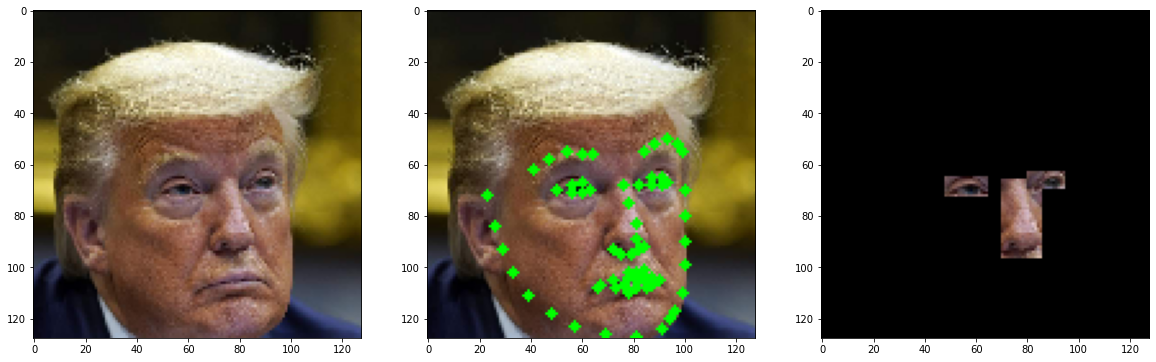

In [13]:
img = Image.open('trump.jpg').convert('RGB')
w, h = img.size
target_w = 800
target_h = 800
ratio = max(target_w / w, target_h / h)
img = img.resize((int(w * ratio), int(h * ratio)))
img = np.array(img)
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')

# detect_landmarks
preds = fa.get_landmarks(img)

# detect bbox
pts = np.array(preds[0])
x_min = pts[:,0].min()
x_max = pts[:,0].max()
y_min = pts[:,1].min()
y_max = pts[:,1].max()
# crop the face and resize it if larger than given size 128
if img.shape[0] > 128:
    img = Image.fromarray(img)
    y_extend = 2 / 3 * (y_max - y_min)
    img = img.crop((x_min-y_extend//2, y_min-y_extend, x_max+y_extend//2, y_max)).resize((128,128))
    img = np.array(img)
    plt.imshow(img)
    
# detect_landmarks again    
preds = fa.get_landmarks(img)
input_with_FL = img.copy()
for (x, y) in preds[0]:
   cv2.circle(input_with_FL, (x, y), 2, (0, 255, 0), -1)

def get_face_mask(img, preds):
    mask = np.zeros((img.shape[0], img.shape[1]))

    ############### left eye ####################
    left_eye = preds[0][36:42]
    n = 2
    left_eye_mask = np.zeros((img.shape[0], img.shape[1]))
    left_eye_mask[int(min(left_eye[:,1])-n):int(max(left_eye[:,1])+n), int(min(left_eye[:,0])-n):int(max(left_eye[:,0])+n)] = 1

    ############### right eye ####################
    right_eye = preds[0][42:48]
    n = 2
    right_eye_mask = np.zeros((img.shape[0], img.shape[1]))
    right_eye_mask[int(min(right_eye[:,1])-n):int(max(right_eye[:,1])+n), int(min(right_eye[:,0])-n):int(max(right_eye[:,0])+n)] = 1

    ############### nose ####################
    nose = preds[0][27:36]
    n = 2
    nose_mask = np.zeros((img.shape[0], img.shape[1]))
    nose_mask[int(min(nose[:,1])-n):int(max(nose[:,1])+n), int(min(nose[:,0])-n):int(max(nose[:,0])+n)] = 1

    mask += left_eye_mask
    mask += right_eye_mask
    mask += nose_mask
    mask[mask>0] = 1

    crop_face = np.zeros((img.shape))
    for i in range(3):
        crop_face[:,:,i] = img[:,:,i]*mask
    return mask, crop_face
mask, crop_face = get_face_mask(img, preds)


plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1,3,1); plt.imshow(img)
plt.subplot(1,3,2); plt.imshow(input_with_FL)
plt.subplot(1,3,3); plt.imshow(crop_face/255)

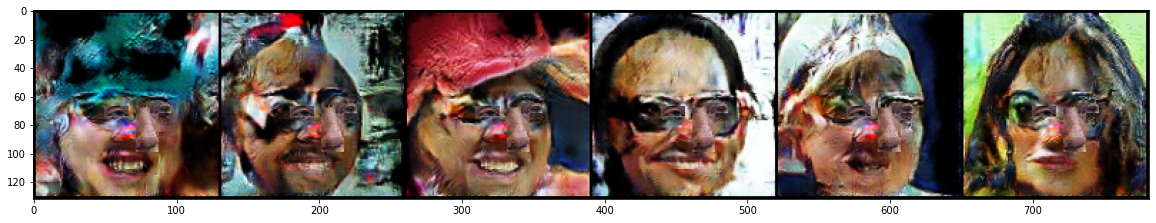

In [14]:
num_sample = 6 # number of faces you want to sample
    
rgb =  torch.from_numpy(crop_face).unsqueeze(0).transpose(1,3).transpose(2,3).float() # torch.ones((1,3,128,128))
mask = torch.from_numpy(mask).unsqueeze(0).float()[None, :] # mask = torch.ones((1,3,128,128))
# process inptus
mask[mask>0] = 1
cond_input = rgb*mask
rgb, cond_input = norm(rgb), norm(cond_input)

# load models
encoder = torch.load('models/encoder_29.pt', map_location=lambda storage, loc: storage)
decoder = torch.load('models/decoder_29.pt', map_location=lambda storage, loc: storage)

# Sample Style Code 
batch = rgb.shape[0]
style_codes = torch.FloatTensor(batch, num_sample, 512).uniform_().view(-1,512)

# Encode occluded face image 
code = encoder(cond_input)

# Decode face image
rgb_hat = decoder(code, style_codes)[-1]

output = torch.zeros_like(rgb_hat)
for i in range(num_sample):
    output[i] = mask * rgb + (1 - mask) * rgb_hat[i]
demo = make_grid(output, nrow=num_sample, padding=2, normalize=True)
demo_np = demo.transpose(0,2).transpose(0,1).detach().numpy()
plt.imshow(demo_np)